In [4]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
from tqdm import tqdm_notebook as lol
import time
import scipy
import rep_pybeh as rpb
from plotting import *
error_bars ={'elinewidth':3, 'capsize':5, 'capthick':3}
data_set = 'hospital'

## Hospital Data Load

In [7]:
if data_set == 'hospital':
    evs = []
    data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'RepFR1']
    for subject, df in data.groupby('subject'):
        for session in pd.unique(df['session']):
            try:
                r = cml.CMLReader(subject=subject, experiment='RepFR1', session=session)
                temp = r.load('task_events')
                evs.append(temp)
            except: print('subj', subject, session, "didn't work")
    evs = pd.concat(evs)
    evs = evs[evs.list != 0]
    subs = evs.subject.unique()
    print(len(subs))

subj R1593D 4 didn't work
subj R1593D 5 didn't work
subj R1651J 2 didn't work
50


## Scalp Data Load

In [8]:
if data_set == 'scalp':
    evs = []
    data = cml.get_data_index(kind = 'ltp'); data = data[data['experiment'] == 'ltpRepFR']
    for subject, df in data.groupby('subject'):
        for session in pd.unique(df['session']):
            r = cml.CMLReader(subject=subject, experiment='ltpRepFR', session=session)
            temp = r.load('all_events')
            evs.append(temp)
    evs = pd.concat(evs)
    evs = evs[evs.list != 0]
    subs = evs.subject.unique()


    print(evs.subject.unique())

In [9]:
evs['serialpos'] = evs.serialpos +1
evs = evs[evs.list != 0]
evs = evs[evs.list != 26]
word_evs = evs[evs.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
rec_evs = evs[evs.type=='REC_WORD']


In [10]:
spc = word_evs.groupby(['subject', 'session', 'list', 'serialpos', 'repeats']).mean().reset_index().groupby(['subject', 'session','serialpos', 'repeats']).mean().reset_index()

spc = spc[['subject', 'session', 'serialpos', 'repeats', 'recalled']]
tot_one = spc.loc[spc.repeats == 1]#.groupby('subject').recalled.mean()
two_spc = spc.loc[spc.repeats == 2]#.groupby('subject').recalled.mean()
thr_spc = spc.loc[spc.repeats == 3]#.groupby('subject').recalled.mean()

sub_mean = spc.groupby(['subject', 'serialpos', 'repeats']).recalled.mean().reset_index()
grand_mean = sub_mean.groupby(['serialpos', 'repeats']).mean()
sub_mean = sub_mean.reset_index().set_index(['serialpos', 'repeats'])
sub_mean['grand_mean'] = grand_mean
sub_mean['adjustment'] = sub_mean.grand_mean - sub_mean.recalled
sub_mean = sub_mean.reset_index().set_index(['subject', 'serialpos', 'repeats'])
spc = spc.set_index(['subject', 'serialpos', 'repeats', 'session'])
spc['adj_rec'] = spc.recalled + sub_mean['adjustment']

spc = spc.reset_index()
# sns.lineplot(data = spc, x = 'serialpos', y = 'adj_rec', hue = 'repeats')

In [11]:
# one_spc = spc.loc[spc.repeats == 1]
# # two_spc = spc.loc[spc.repeats == 2].groupby('subject').adj_rec.mean()
# # thr_spc = spc.loc[spc.repeats == 3].groupby('subject').adj_rec.mean()

# # ci_two = 1.96*two_spc.std()/(7**0.5)
# # ci_thr = 1.96*thr_spc.std()/(7**0.5)
# # mu_two = two_spc.mean()
# # mu_thr = thr_spc.mean()
# # print(ci_two)

# fig, ax = set_axes(figsize = (14, 7), xticks = np.arange(1, 28), ylim = [0,1], yticks = np.arange(0, 1.1, .1))
# g1 = sns.lmu_two, color = 'slategray', linestyle = '--', xmin=1.2/28, xmax=26.8/28, label = 'Two')
# ax.axhspan(ineplot(data = one_spc, x = 'serialpos', y = 'adj_rec', err_style = 'band', ci = 95, marker = 'o', color = 'navy', label = 'One')
# ax.axhline((mu_two-ci_two), (mu_two+ci_two), color='gray', alpha=0.2, xmin=1.2/28, xmax=26.8/28)
# ax.axhline(mu_thr, color = 'black', linestyle = '--', xmin=1.2/28, xmax=26.8/28, label ='Three')
# ax.axhspan((mu_thr-ci_thr), (mu_thr+ci_thr), color='black', alpha=0.2, xmin=1.2/28, xmax=26.8/28)

# # g2 = sns.lineplot(data = one_spc, x = 'serialpos', y = 'two_spc', err_style = 'band', ci = 95, color = 'gray', label = 'Twice Presented')
# # g3 = sns.lineplot(data = one_spc, x = 'serialpos', y = 'thr_spc', err_style = 'band', ci = 95, color = 'black', label = 'Thrice Presented')

# _ = plt.xlabel('Serial Position')
# _ = plt.ylabel('Recall Proportion')

# # _ = plt.ylim([0, 1])
# _ = plt.legend(title='Presentations')
# # # plt.savefig(data_set +'_spc.pdf')

In [12]:
spc = word_evs.groupby(['subject', 'session', 'list', 'serialpos', 'repeats']).mean().reset_index().groupby(['subject', 'session','serialpos', 'repeats']).mean().reset_index()

spc = spc[['subject', 'session', 'serialpos', 'repeats', 'recalled']]
one_spc = spc.loc[spc.repeats == 1]
cuts = pd.qcut(one_spc.serialpos, 9)
one_spc = one_spc.groupby(['subject', 'session', cuts]).mean()


one_spc = one_spc.drop('serialpos', axis=1)
# one_spc.reset_index(inplace=True)
# one_spc.serialpos.apply(pd.Interval.left)
one_spc['spos_bins'] = (pd.IntervalIndex(one_spc.index.get_level_values('serialpos')).left+3)/3
one_spc['spos_bins'] = round(one_spc.spos_bins)
one_spc = one_spc.reset_index().drop('serialpos', 1)


sub_mean = one_spc.groupby(['subject', 'spos_bins', 'repeats']).recalled.mean().reset_index()
grand_mean = sub_mean.groupby(['spos_bins', 'repeats']).mean()
sub_mean = sub_mean.reset_index().set_index(['spos_bins', 'repeats'])
sub_mean['grand_mean'] = grand_mean
sub_mean['adjustment'] = sub_mean.grand_mean - sub_mean.recalled
sub_mean = sub_mean.reset_index().set_index(['subject', 'spos_bins', 'repeats'])
one_spc = one_spc.set_index(['subject', 'spos_bins', 'repeats', 'session'])
one_spc['adj_rec'] = one_spc.recalled + sub_mean['adjustment']
one_spc = one_spc.reset_index()
one_spc.to_csv(data_set+'_spc.csv')

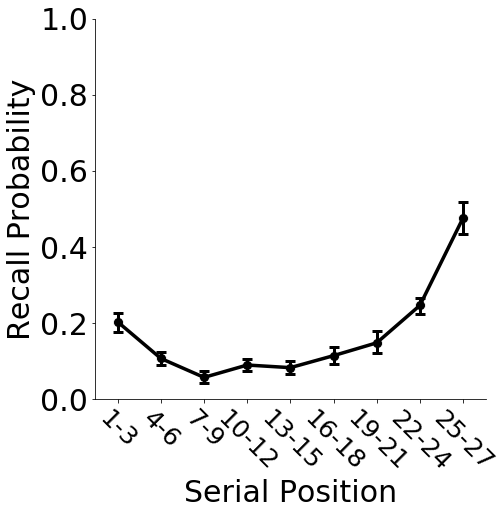

In [13]:
# two_spc = spc.loc[spc.repeats == 2].groupby('subject').adj_rec.mean()
# thr_spc = spc.loc[spc.repeats == 3].groupby('subject').adj_rec.mean()

# ci_two = 1.96*two_spc.std()/(7**0.5)
# ci_thr = 1.96*thr_spc.std()/(7**0.5)
# mu_two = two_spc.mean()
# mu_thr = thr_spc.mean()
spos_bins = []

fig, ax = set_axes(figsize = (7, 7), xticks = np.arange(1, 28), yticks = np.arange(0, 1.1, .2), ylim=[0,1], fontsize = 30)
g1 = sns.lineplot(data = one_spc, x = 'spos_bins', y = 'adj_rec', 
                  err_style = 'bars', ci = 95, color = 'black', linewidth = 3.5, err_kws = error_bars)
g1 = sns.scatterplot(data = one_spc.groupby('spos_bins').mean().reset_index(), x = 'spos_bins', y = 'adj_rec', color = 'black', s = 100)
# ax.axhline(mu_two, color = 'slategray', linestyle = '--', xmin=1.2/28, xmax=26.8/28, label = 'Two')
# ax.axhspan((mu_two-ci_two), (mu_two+ci_two), color='gray', alpha=0.2, xmin=1.2/28, xmax=26.8/28)
# ax.axhline(mu_thr, color = 'black', linestyle = '--', xmin=1.2/28, xmax=26.8/28, label ='Three')
# ax.axhspan((mu_thr-ci_thr), (mu_thr+ci_thr), color='black', alpha=0.2, xmin=1.2/28, xmax=26.8/28)

# g2 = sns.lineplot(data = one_spc, x = 'serialpos', y = 'two_spc', err_style = 'band', ci = 95, color = 'gray', label = 'Twice Presented')
# g3 = sns.lineplot(data = one_spc, x = 'serialpos', y = 'thr_spc', err_style = 'band', ci = 95, color = 'black', label = 'Thrice Presented')

_ = plt.xlabel('Serial Position')
_ = plt.ylabel('Recall Probability')
labels=['1-3', '4-6', '7-9', '10-12', '13-15', '16-18', '19-21', '22-24', '25-27']
plt.xticks(np.arange(1,10,1), labels=labels, rotation = -45, fontsize = 25)
# plt.legend(title='Presentations')
# # # _ = plt.ylim([0, 1])
# _ = plt.legend(title='Presentations')
plt.savefig(data_set+'_figs/binned_spc.pdf', bbox_inches='tight')

In [14]:
# reps = pd.DataFrame(columns = ['Presentations', 'Recall Rate', ])

In [15]:
tot_one = tot_one.reset_index()
# tot_one['Presentations'] = pd.Series('One', index = two_spc.index)

two_spc = two_spc.reset_index()
# two_spc['Presentations'] = pd.Series('Two', index = two_spc.index)
thr_spc = thr_spc.reset_index()
# thr_spc['Presentations'] = pd.Series('Three', index = thr_spc.index)
reps = tot_one.append([two_spc, thr_spc]).reset_index()
scatter_reps = reps.copy().groupby(['subject', 'repeats']).mean()

In [16]:
reps = reps.groupby(['subject', 'session', 'repeats']).recalled.mean().reset_index()
display(reps.groupby(['repeats']).recalled.mean())
sub_mean = reps.groupby(['subject', 'repeats']).recalled.mean().reset_index()
grand_mean = sub_mean.groupby(['repeats']).mean()
sub_mean = sub_mean.reset_index().set_index(['repeats'])
sub_mean['grand_mean'] = grand_mean
sub_mean['adjustment'] = sub_mean.grand_mean - sub_mean.recalled
sub_mean = sub_mean.reset_index().set_index(['subject', 'repeats'])
reps = reps.set_index(['subject', 'repeats', 'session'])
reps['adj_rec'] = reps.recalled + sub_mean['adjustment']
reps = reps.reset_index()
reps.to_csv(data_set+'_reps.csv')
# reps.groupby('repeats').recalled.mean()

repeats
1    0.160218
2    0.308043
3    0.446687
Name: recalled, dtype: float64

In [17]:
scatter_reps.reset_index(inplace=True)
# scatter_reps['repeats'] = scatter_reps['repeats'] - 1

In [18]:
palette = []
for i in subs:
    palette.append('black')

In [19]:
# set_axes(fontsize = 30)

# g = sns.barplot(data=reps, x = 'repeats', y = 'adj_rec', 
#                 ci = 95, zorder= 0, capsize=0.075, linestyle = "-", linewidth = 2, **dict(edgecolor="black", fill = False))
# g = sns.scatterplot(data=scatter_reps, x = 'repeats', y = 'recalled', ci = 95, hue = 'subject', palette = palette, legend=None, s=100)


# _ = plt.ylabel('Recall Probability')
# plt.savefig(data_set+'_figs/recall_by_pres.pdf')

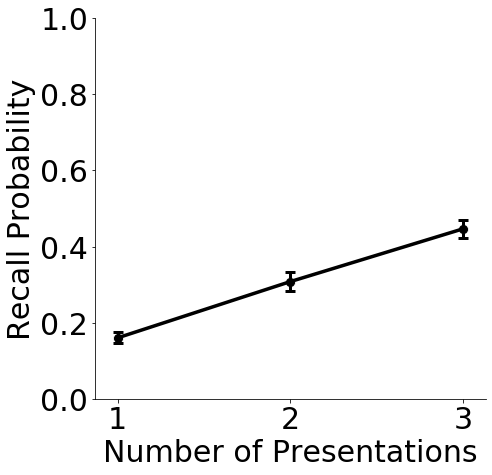

In [20]:
set_axes(fontsize = 30, ylim = [0,1], xticks = np.arange(1, 4, 1))
# g = sns.lineplot(data=scatter_reps, x = 'repeats', y = 'recalled', ci = 95, hue = 'subject', palette = palette, **dict(alpha=0.3), legend=None)

g = sns.lineplot(data=reps, x = 'repeats', y = 'recalled', err_style = 'bars',
                ci = 95, color = 'black', linewidth = 3.5, err_kws = error_bars)
g = sns.scatterplot(data=reps.groupby('repeats').mean().reset_index(), x = 'repeats', y = 'recalled', color = 'black', s= 100)
_ = plt.ylabel('Recall Probability')
_ = plt.xlabel('Number of Presentations')
plt.savefig(data_set+'_figs/recall_by_pres.pdf', bbox_inches='tight')